In [1]:
%%time
import sys
#!{sys.executable} -m pip install -r requirements.txt


CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 12.9 µs


In [2]:
%%time
import boto3
import datetime
import json
import math 
import matplotlib.pyplot as plt   
from matplotlib import pyplot
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import sagemaker
from  sagemaker.serializers import LibSVMSerializer
from  sagemaker.deserializers import StringDeserializer
from sagemaker.amazon.amazon_estimator import get_image_uri
import seaborn  
from sklearn.datasets import dump_svmlight_file   
from sklearn.metrics import * 
from sklearn.model_selection import train_test_split
import time
from xgboost import XGBClassifier

def date_s():
  return datetime.datetime.now().isoformat().replace('.','-').replace(':','-')[:-7] +'Z' 
print('Start at', date_s())

Start at 2020-12-02T12-52-20Z
CPU times: user 1.58 s, sys: 120 ms, total: 1.7 s
Wall time: 1.7 s


In [3]:
%%time

session = sagemaker.Session() 
region = session.boto_region_name 

bucket = 'sagemaker-jfox'
prefix = 'sagemaker/xgboost'
role = sagemaker.get_execution_role()

print(f'Bucket {bucket} in region {region}')

Bucket sagemaker-jfox in region eu-west-1
CPU times: user 201 ms, sys: 12.4 ms, total: 213 ms
Wall time: 2.26 s


In [4]:
%%time
filename='from_databrew.parquet.snappy' 
s3 = boto3.resource('s3', region_name=region)

#s3.Bucket(bucket).download_file(
# 'normalize-3-snappy-parquet/normalize-3_02Dec2020_1606903905135/normalize-3_02Dec2020_1606903905135_part00000.parquet.snappy',
#    filename)
table = pq.read_table(filename)
df = table.to_pandas()    
    
print('Length', len(df))

Length 6362620
CPU times: user 1.08 s, sys: 727 ms, total: 1.8 s
Wall time: 1.65 s


In [5]:
df = df.sample(frac=0.0001, replace=True, random_state=1)
print('Length after downsampling', len(df))
df

Length after downsampling 636


,isFraud,hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount_nml,oldBalanceOrigin_nml,newBalanceOrigin_nml,oldBalanceDestination_nml,newBalanceDestination_nml
4322341,0,20.0,0,0,0,1,0,-0.229409,-0.287947,-0.292442,-0.323814,-0.333411
4686059,0,19.0,0,0,0,1,0,-0.288739,-0.288716,-0.292442,-0.323814,-0.333411
3937352,0,22.0,0,1,0,0,0,-0.085726,-0.288716,-0.292442,2.193641,2.030517
491263,0,19.0,0,1,0,0,0,-0.064778,-0.288716,-0.292442,0.229449,0.216756
5030793,0,18.0,0,1,0,0,0,-0.037904,-0.199619,-0.258119,1.646407,1.532095
...,...,...,...,...,...,...,...,...,...,...,...,...
982954,0,20.0,0,1,0,0,0,-0.166072,-0.288716,-0.292442,-0.282537,-0.273564
4763286,0,22.0,0,0,0,1,0,-0.270027,-0.266996,-0.276734,-0.323814,-0.333411
2518482,0,13.0,0,0,0,1,0,-0.289647,-0.263620,-0.269347,-0.323814,-0.333411
5828776,0,18.0,0,0,0,1,0,-0.289704,-0.230923,-0.237039,-0.323814,-0.333411


In [6]:
target_col='isFraud'

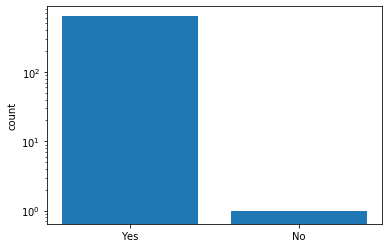

In [7]:
def plot_positive_negative_counts(df, target_col):
    val_counts=df['isFraud'].value_counts()
    fig, ax = plt.subplots()
    ax.set(yscale='log')
    plt.bar(['Yes', 'No'], val_counts)
    plt.ylabel('count')
    plt.show()
    
plot_positive_negative_counts(df,'isFraud')

ValueError: zero-size array to reduction operation minimum which has no identity

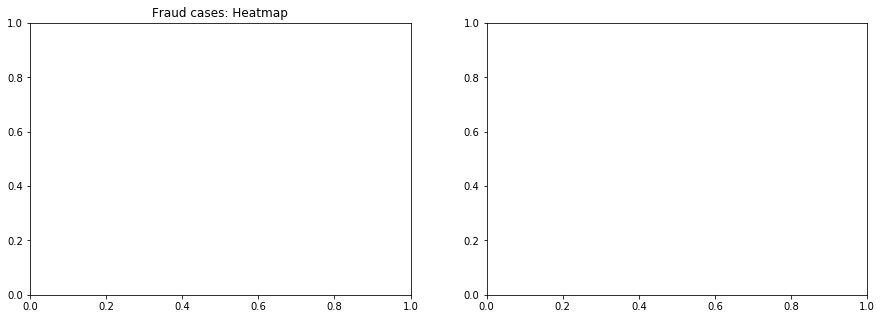

In [8]:
fig, axes = plt.subplots( 1,2, figsize=(15,5))

def heatmap(fraud_cases):
    lbl = 'Fraud' if  fraud_cases else 'Non-fraud'
    # Coerced to int, below
    axes[1-fraud_cases].set_title(f'{lbl} cases: Heatmap')
    seaborn.heatmap(df.query(f'isFraud == {fraud_cases}').drop(['isFraud'], 1).corr(),  cmap='Oranges', ax=axes[1-fraud_cases])

heatmap(True)
heatmap(False)

plt.show()

In [ ]:
HOURS_IN_DAY  =24

frauds_by_hour = []
non_frauds_by_hour = []
hourwise_items = []
for hour in range(HOURS_IN_DAY):
    non_fraud_in_hour = df[(df['hour'] == hour) & (df['isFraud'] == 0)]
    non_fraud_sum_in_hour = len(non_fraud_in_hour)
    fraud_in_hour = df[(df['hour'] == hour) & (df['isFraud'] == 1)]
    fraud_sum_in_hour = len(fraud_in_hour)
    non_frauds_by_hour.append(non_fraud_sum_in_hour)
    frauds_by_hour.append(fraud_sum_in_hour)
    hourwise_items.append(non_fraud_sum_in_hour+fraud_sum_in_hour)

fig, ax = plt.subplots(figsize=(11, 7))
 
fr_non_fraud = ax.plot(np.multiply(np.divide(frauds_by_hour,hourwise_items), 100), label='Fraud percentage by hour')
plt.xticks(np.arange(24))
legend = ax.legend(loc='upper left' )
 

In [10]:
conditions=[(df['hour'] >=2) & (df['hour'] <=6)]
series = pd.Series(np.select(conditions, [1], 0))
df['peakHours']=series
df

,isFraud,hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount_nml,oldBalanceOrigin_nml,newBalanceOrigin_nml,oldBalanceDestination_nml,newBalanceDestination_nml,peakHours
4322341,0,20.0,0,0,0,1,0,-0.229409,-0.287947,-0.292442,-0.323814,-0.333411,NaN
4686059,0,19.0,0,0,0,1,0,-0.288739,-0.288716,-0.292442,-0.323814,-0.333411,NaN
3937352,0,22.0,0,1,0,0,0,-0.085726,-0.288716,-0.292442,2.193641,2.030517,NaN
491263,0,19.0,0,1,0,0,0,-0.064778,-0.288716,-0.292442,0.229449,0.216756,NaN
5030793,0,18.0,0,1,0,0,0,-0.037904,-0.199619,-0.258119,1.646407,1.532095,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
982954,0,20.0,0,1,0,0,0,-0.166072,-0.288716,-0.292442,-0.282537,-0.273564,NaN
4763286,0,22.0,0,0,0,1,0,-0.270027,-0.266996,-0.276734,-0.323814,-0.333411,NaN
2518482,0,13.0,0,0,0,1,0,-0.289647,-0.263620,-0.269347,-0.323814,-0.333411,NaN
5828776,0,18.0,0,0,0,1,0,-0.289704,-0.230923,-0.237039,-0.323814,-0.333411,NaN


In [13]:
df

,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount_nml,oldBalanceOrigin_nml,newBalanceOrigin_nml,oldBalanceDestination_nml,newBalanceDestination_nml,peakHours
4322341,0,0,0,0,1,0,-0.229409,-0.287947,-0.292442,-0.323814,-0.333411,NaN
4686059,0,0,0,0,1,0,-0.288739,-0.288716,-0.292442,-0.323814,-0.333411,NaN
3937352,0,0,1,0,0,0,-0.085726,-0.288716,-0.292442,2.193641,2.030517,NaN
491263,0,0,1,0,0,0,-0.064778,-0.288716,-0.292442,0.229449,0.216756,NaN
5030793,0,0,1,0,0,0,-0.037904,-0.199619,-0.258119,1.646407,1.532095,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4652788,0,0,1,0,0,0,0.376096,-0.288716,-0.292442,2.435579,2.330252,NaN
2038481,0,0,0,0,0,1,1.197950,-0.284519,-0.292442,-0.188643,0.037486,NaN
4151813,0,0,1,0,0,0,0.264163,-0.281222,-0.292442,0.054436,0.108903,NaN
1404109,0,0,1,0,0,0,0.170978,-0.281307,-0.292442,-0.323814,-0.256357,NaN


In [11]:
%%time
len_ = len(df)
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.5 * len_), int(0.7 * len_)])

lengths = [] 

for d in [(train_data, 'train.libsvm'), ( validation_data, 'validation.libsvm'), (test_data, 'test.libsvm')]:
   dataset=d[0]
   file_ = d[1]
   lengths.append((d[1].split('.')[0],len(dataset)))
   dump_svmlight_file(X=dataset.drop([target_col], axis=1), y=dataset[target_col], f=d[1])

print('Length of datasets:', lengths )

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [12]:
s3 = boto3.resource('s3', region_name=region)#TODO Remove

for filename in ['train.libsvm', 'validation.libsvm']:
   s3.Bucket(bucket).Object(prefix + '/'+filename.split('.')[0]+'/'+filename).upload_file(filename)

FileNotFoundError: [Errno 2] No such file or directory: 'validation.libsvm'

In [ ]:
def s3_path(subset):
  return sagemaker.TrainingInput(s3_data='s3://{}/{}/{}'.format(bucket, prefix,subset), content_type='libsvm')

s3_input_train = s3_path('train')
s3_input_validation =s3_path('validation')

In [ ]:
container = get_image_uri(region, 'xgboost','1.0-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    base_job_name='fraud-detection-job',
                                    train_instance_count=1, 
                                    train_instance_type='ml.c5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=session)


#xgb.set_hyperparameters() Use defaults

 
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})


serializer = LibSVMSerializer()
deserializer = StringDeserializer() 
deserializer.CONTENT_TYPE = "text/libsvm"

model = xgb.create_model()

container_def = model.prepare_container_def(instance_type='ml.m4.xlarge')


model_name = 'fraud-' +date_s()
print('model_name', model_name)
 
endpoint_name = 'fraud-detection-endpoint'
 
def deploy_on_new_endpoint():
      print('deploy on new endpoint')
      ret_unused_because_no_ser_deser = xgb.deploy(endpoint_name=endpoint_name, model_name=model_name,
                                 initial_instance_count=1, instance_type='ml.m5.xlarge', accelerator_type='ml.eia2.medium')
      ret = sagemaker.predictor.Predictor(endpoint_name=endpoint_name, 
                                              sagemaker_session=sagemaker.Session(),
                                              serializer=serializer,
                                              deserializer = deserializer
                                             )
  

      return ret
    
def deploy_on_existing_endpoint():
        print('deploy on existing endpoint') 
        session.create_model(model_name, role, container_def)
        
        endpoint_config_name = session.create_endpoint_config(name=model_name+date_s(),
                                                      model_name=model_name,
                                                      initial_instance_count=1,
                                                      instance_type='ml.m5.xlarge',
                                                      accelerator_type='ml.eia2.medium')
        
        client = boto3.client('sagemaker')
        updated_endpoint=client.update_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
     

        ret = sagemaker.predictor.Predictor(endpoint_name=endpoint_name, 
                                              sagemaker_session=sagemaker.Session(),
                                              serializer=serializer,
                                              deserializer = deserializer
                                             )
 
        return ret
 
 
while True:
  try:
     xgb_predictor= deploy_on_existing_endpoint()
     break
  except Exception as e:
      if 'Cannot update in-progress endpoint' in str(e):
        print('Cannot update in-progress endpoint')
        time.sleep(30)
        continue
      elif 'Could not find endpoint' in str(e):
        print('Could not find endpoint')
        xgb_predictor= deploy_on_new_endpoint()
        break;
      else:
        print("Exception", e)
        break
      
print('Finished deployment', date_s())

In [ ]:
def do_predict(data):
    payload = '\n'.join(data)
    response = xgb_predictor.predict(payload) 
    result = response.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items]))
        sys.stdout.write('.')
    return(arrs)
 

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100)

actual_pos = sum(1 for i in range(len(labels)) if 1==labels[i])
actual_neg = sum(1 for i in range(len(labels)) if 0==labels[i])

pred_pos = sum(1 for i in range(len(preds)) if 1==preds[i])
pred_neg = sum(1 for i in range(len(preds)) if 0==preds[i])

true_pos = sum(1 for i in range(len(preds)) if preds[i]==1==labels[i])
true_neg = sum(1 for i in range(len(preds)) if preds[i]==0==labels[i])

false_pos=sum(1 for i in range(len(preds)) if preds[i]==1 and 0==labels[i])
false_neg=sum(1 for i in range(len(preds)) if preds[i]==0 and 1==labels[i])

recall = true_pos/(true_pos+false_neg)
precision = true_pos/(true_pos+false_pos)
f1 = (2 * precision * recall) / (precision + recall)
error = sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))
assert recall <= f1 <= precision or precision <= f1 <= recall 
assert true_pos + false_neg == actual_pos
assert true_neg + false_pos == actual_neg
#print('pred_pos', pred_pos,'pred_neg', pred_neg)

assert len(preds)==len(labels)

#print(len(preds), 'predictions and labels')

#print('actual_pos', actual_pos, 'actual_neg', actual_neg)
assert actual_pos+actual_neg==len(labels)
                   
#print('true_pos', true_pos, 'false_pos', false_pos)
#assert  true_pos+false_pos == pred_pos

#print('true_neg', true_neg, 'false_neg', false_neg )
assert true_neg+false_neg== pred_neg

#print('pred_pos+pred_neg',pred_pos+pred_neg)
assert pred_pos+pred_neg==len(preds)

print(f'Recall={recall:.2f}')
print(f'Precision={precision:.2f}')
print(f'Error rate={error:.2f}')
print(f'F1={f1:.2f}')
pd.crosstab(index=np.array(labels), columns=np.array(preds), rownames=['actual fraud'],  colnames=['predicted as fraud'])
sys.exit(0)

In [ ]:
dataset = df.to_numpy()
X = dataset[:,1:]
y = dataset[:,0]

In [ ]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

In [ ]:
%%time
print(f'Start fit at {date_s()}')
model = XGBClassifier( objective='binary:logistic', scale_pos_weight=5 )
model.fit(X, y, verbose=True)

In [ ]:
%%time

fields_short_names = [s.replace('balance', 'Bal') for s in df.columns[1:]]
 
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_, tick_label=fields_short_names)
        
pyplot.show()

In [ ]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# Not auc, roc_auc_score
functions = [accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score ]
for f in functions:
  print("%s: %.2f%%" % (f.__name__, f(y_test, predictions) * 100.0))

plot_precision_recall_curve(model, X_test, y_test)  